## SETUP inicial
Aqui importamos as principais bibliotecas e definimos algumas configurações para a exploração dos dados. 
Vou utilizar um random state fixo de 42 para garantir a reprodutibilidade do modelo

### Objetivo
Este notebook tem como objetivo realizar o pré-processamento dos dados para o desenvolvimento do modelo.<br>
 As etapas incluem separação temporal dos dados, tratamento de valores ausentes, análise de multicolinearidade, avaliação do poder discriminatório das variáveis e definição das bases finais para modelagem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 80)
pd.set_option("display.float_format", "{:.4f}".format)

RANDOM_STATE = 42
DATA_PATH = "../data/raw/dataset.csv"

In [2]:
df = pd.read_csv(DATA_PATH)

df.shape

(10738, 81)

### Ordenação temporal e split

In [3]:
df = df.sort_values('safra')

train = df[df['safra'] <= 201406]
val   = df[(df['safra'] > 201406) & (df['safra'] <= 201409)]
test  = df[df['safra'] > 201409]


A separação temporal foi adotada para evitar vazamento de informação e refletir o cenário real de concessão de crédito, garantindo que o modelo seja treinado exclusivamente com dados históricos e avaliado em dados futuros

### Tratamento de valores ausentes
Aqui vamos separar as variaveis das colunas especiais de predição, safra e id

In [4]:
features = train.columns.tolist()

cols_to_remove = ['id', 'safra', 'y']
features = [col for col in features if col not in cols_to_remove]

In [5]:
missing_rate = train.isnull().mean().sort_values(ascending=False)
missing_rate.head(5)


VAR_62   0.7921
VAR_70   0.7842
VAR_61   0.7233
VAR_49   0.6949
VAR_36   0.6856
dtype: float64

Variaveis com mais de 40% de valores ausentes foram removidas por risco de instabilidade e baixa representatividade.

In [6]:
high_missing_cols = missing_rate[missing_rate > 0.40].index.tolist()

train = train.drop(columns=high_missing_cols)
val   = val.drop(columns=high_missing_cols)
test  = test.drop(columns=high_missing_cols)

features = [col for col in features if col not in high_missing_cols]



### Imputação de valores
Para as variaveis com taxa de nulos menor do que 40% vamos utilizar duas estratégias de imputação para avaliar o impacto do tratamento na performance do modelo. <br>
Vamos utilizar:<br>
- Mediana<br>
- Média<br>

Vamos criar uma função para realizar essas imputações e separar em dois dataframes diferentes para cada imputação.

In [7]:
def imputacao(df, cols, strategy='median', reference=None):
    df = df.copy()
    
    for col in cols:
        
        # imputação
        if reference is not None:
            # usar valor do treino
            fill_value = reference[col]
        else:
            # calcular no próprio df
            if strategy == 'median':
                fill_value = df[col].median()
            elif strategy == 'mean':
                fill_value = df[col].mean()
            else:
                raise ValueError("strategy deve ser 'median' ou 'mean'")
        
        df[col] = df[col].fillna(fill_value)
    
    return df


Aqui vamos aplicar as imputações criando dois datasets. Um para cada pipeline. Em seguida vamos iniciar a identificação e tratamento de outliers.

In [8]:
# --- Treino ---
df_mediana = imputacao(train, features, strategy='median')
df_media = imputacao(train, features, strategy='mean')

# --- Referências do treino ---
medianas = df_mediana[features].median()
medias = df_media[features].mean()

# --- Validação ---
df_validacao_mediana = imputacao(val, features, strategy='median', reference=medianas)
df_validacao_media = imputacao(val, features, strategy='mean', reference=medias)

# --- Teste ---
df_teste_mediana = imputacao(test, features, strategy='median', reference=medianas)
df_teste_media = imputacao(test, features, strategy='mean', reference=medias)


In [9]:
def identifica_outliers_iqr(df, features, factor=1.5):
    outlier_cols = []
    
    for col in features:
        # Se for binária ou tiver poucos valores únicos, ignora
        if df[col].nunique() <= 2:
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - (factor * IQR)
        upper_bound = Q3 + (factor * IQR)
        
        # Verifica se existe algum valor fora dos limites
        if ((df[col] < lower_bound) | (df[col] > upper_bound)).any():
            outlier_cols.append(col)
            
    return outlier_cols

In [10]:
def fit_woe_binning(df, features_to_treat, target='y', n_bins=10):
    woe_maps = {}
    
    for col in features_to_treat:
        try:
            # 1. Criação dos Bins (qcut para quantis iguais)
            # duplicates='drop' lida com variaveis que tem muitos valores repetidos (ex: zeros)
            df_temp = df[[col, target]].copy()
            df_temp['bin'], bins = pd.qcut(df_temp[col], q=n_bins, duplicates='drop', retbins=True)
            
            # Ajusta limites para garantir cobertura no infinito (para validação/teste)
            bins[0] = -np.inf
            bins[-1] = np.inf
            
            # 2. Calculo do WoE por bin
            grouped = df_temp.groupby('bin', observed=False)[target].agg(['count', 'sum'])
            grouped.columns = ['total', 'bad']
            grouped['good'] = grouped['total'] - grouped['bad']
            
            # Evita divisão por zero adicionando um pequeno smoothing se necessário
            # Aqui assumimos que a base é grande o suficiente, mas tratamos zeros
            total_bad = grouped['bad'].sum()
            total_good = grouped['good'].sum()
            
            if total_bad == 0 or total_good == 0:
                print(f"Aviso: Variável {col} não tem eventos suficientes para WoE.")
                continue

            grouped['dist_bad'] = grouped['bad'] / total_bad
            grouped['dist_good'] = grouped['good'] / total_good
            
            # WoE = ln(Dist_Good / Dist_Bad)
            # np.where lida com bins que podem ter 0 bads ou 0 goods
            grouped['woe'] = np.log((grouped['dist_good'] + 0.0001) / (grouped['dist_bad'] + 0.0001))
            
            # Armazena o mapa (bins e dicionario de woe)
            # Mapeamos o intervalo (cat.categories) para o valor de WoE
            woe_dict = grouped['woe'].to_dict()
            
            woe_maps[col] = {
                'bins': bins,
                'woe_values': grouped['woe'].tolist() # Lista ordenada pelos bins
            }
            
        except Exception as e:
            print(f"Erro ao calcular WoE para {col}: {str(e)}")
            continue
            
    return woe_maps

In [11]:
def transform_with_woe(df, woe_maps):
    df_transformed = df.copy()
    
    for col, map_info in woe_maps.items():
        bins = map_info['bins']
        woe_values = map_info['woe_values']
        
        # Cria os bins usando os cortes definidos no treino
        # labels=False retorna o índice do bin (0, 1, 2...)
        # Isso permite usar esse índice para buscar o valor na lista woe_values
        df_transformed[col + '_binned'] = pd.cut(df_transformed[col], bins=bins, labels=False, include_lowest=True)
        
        # Substitui o índice do bin pelo valor de WoE correspondente
        # Fillna(0) ou média do WoE pode ser usado caso caia fora (mas -inf/inf cobre tudo)
        
        # Mapeamento via replace ou map
        # Criar dicionario {indice: woe}
        map_dict = {i: val for i, val in enumerate(woe_values)}
        
        # Substitui a coluna original ou cria nova (aqui vamos substituir para o modelo usar)
        df_transformed[col] = df_transformed[col + '_binned'].map(map_dict).astype(float)
        
        # Remove a coluna auxiliar de bin
        df_transformed.drop(columns=[col + '_binned'], inplace=True)
        
    return df_transformed

In [12]:
outliers_mediana = identifica_outliers_iqr(df_mediana, features)
print(f"Mediana - Variáveis com outliers identificadas: {len(outliers_mediana)}")

# Calcular regras de WoE (Fit no Treino)
woe_maps_mediana = fit_woe_binning(df_mediana, outliers_mediana, target='y')

# Aplicar transformação (Transform no Treino, Validação e Teste)
df_mediana_tratada = transform_with_woe(df_mediana, woe_maps_mediana)
df_validacao_mediana_tratada = transform_with_woe(df_validacao_mediana, woe_maps_mediana)
df_teste_mediana_tratada = transform_with_woe(df_teste_mediana, woe_maps_mediana)

# ==============================================================================
# 2. PIPELINE MÉDIA
# ==============================================================================
outliers_media = identifica_outliers_iqr(df_media, features)
print(f"Média - Variáveis com outliers identificadas: {len(outliers_media)}")

woe_maps_media = fit_woe_binning(df_media, outliers_media, target='y')

df_media_tratada = transform_with_woe(df_media, woe_maps_media)
df_validacao_media_tratada = transform_with_woe(df_validacao_media, woe_maps_media)
df_teste_media_tratada = transform_with_woe(df_teste_media, woe_maps_media)

print("--- Tratamento Concluído ---")

Mediana - Variáveis com outliers identificadas: 20
Média - Variáveis com outliers identificadas: 20
--- Tratamento Concluído ---


In [13]:
def calcula_iv(df, feature, target='y', bins=10):
    data = df[[feature, target]].copy()
    data[feature] = pd.qcut(data[feature], q=bins, duplicates='drop')

    grouped = data.groupby(feature)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']

    grouped['dist_good'] = grouped['good'] / grouped['good'].sum()
    grouped['dist_bad'] = grouped['bad'] / grouped['bad'].sum()

    grouped['woe'] = np.log(grouped['dist_good'] / grouped['dist_bad'])
    grouped['iv'] = (grouped['dist_good'] - grouped['dist_bad']) * grouped['woe']

    return grouped['iv'].sum()


### Análise discriminatória
A métrica Information Value (IV) será utilizada para avaliar a força discriminatória de cada variável, permitindo a eliminação de variáveis potencialmente fracas e servindo como critério de desempate na análise de correlação realizada posteriormente.<br>

Vamos valiar essas métricas a partir dos dados de treinamento e aplicar o corter encontrado para as bases de validação e teste.



Com a função em mãos, vamos calcular o iv das variáveis que temos e armazenar para utilizar posteriormente

In [14]:
# Mediana
iv_values_mediana = {col: calcula_iv(df_mediana_tratada, col) for col in features}
iv_df_mediana = pd.DataFrame.from_dict(iv_values_mediana, orient='index', columns=['iv'])
iv_df_mediana = iv_df_mediana.sort_values('iv', ascending=False)

# Media
iv_values_media = {col: calcula_iv(df_media_tratada, col) for col in features}
iv_df_media = pd.DataFrame.from_dict(iv_values_media, orient='index', columns=['iv'])
iv_df_media = iv_df_media.sort_values('iv', ascending=False)

C:\Users\rique\AppData\Local\Temp\ipykernel_36420\124018134.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(feature)[target].agg(['count', 'sum'])
C:\Users\rique\AppData\Local\Temp\ipykernel_36420\124018134.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(feature)[target].agg(['count', 'sum'])
C:\Users\rique\AppData\Local\Temp\ipykernel_36420\124018134.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 

Com o IV em mãos, vamos retirar as variaveis com IV menor do que 0.02, que indicam variaveis fracas na predição do modelo.

In [15]:
iv_df_mediana = iv_df_mediana[iv_df_mediana['iv'] >= 0.02]
features_mediana = iv_df_mediana.index.tolist()

iv_df_media = iv_df_media[iv_df_media['iv'] >= 0.02]
features_media = iv_df_media.index.tolist()



Agora, vamos calcular a correlação das variáveis e mostrar graficamente. Assim como retirar variaveis com correlação acima de 85%. Removendo a com menor IV.

In [16]:
corr_mediana = df_mediana_tratada[features_mediana].corr().abs()

corr_media = df_media_tratada[features_media].corr().abs()

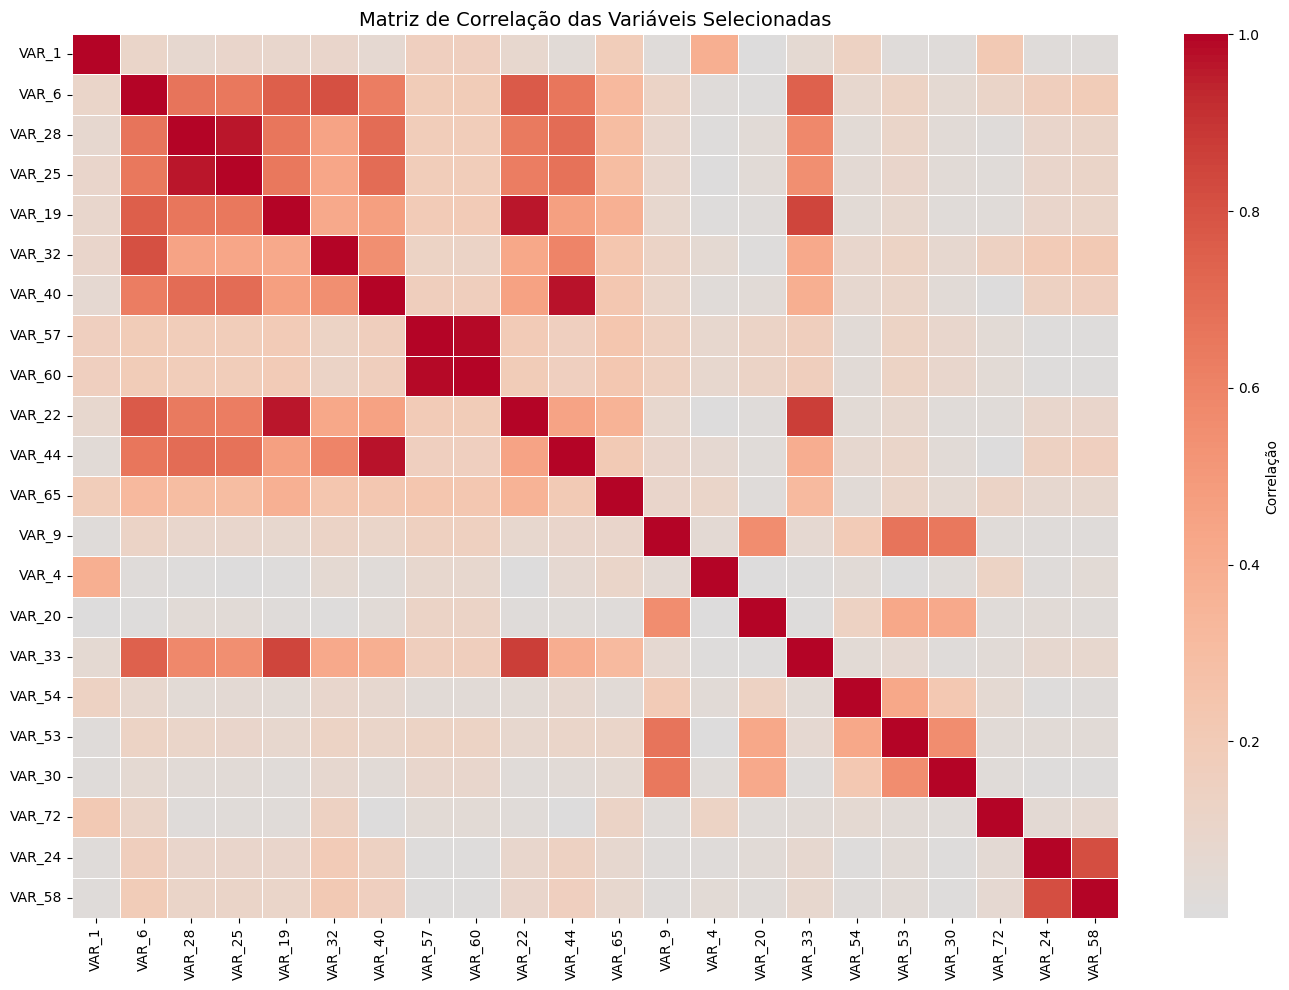

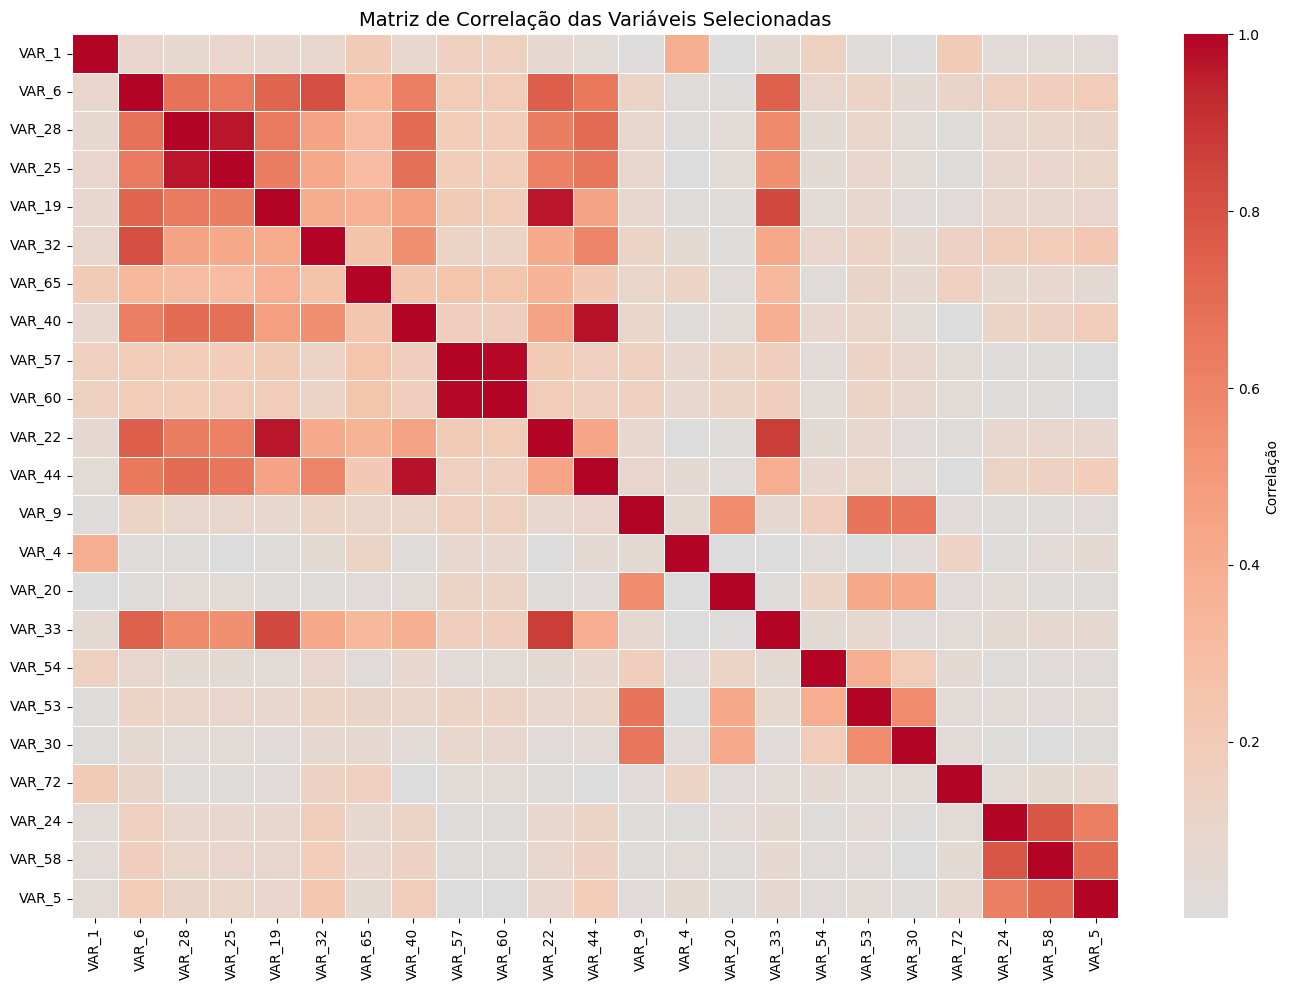

In [17]:
plt.figure(figsize=(14, 10))

sns.heatmap(
    corr_mediana,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlação'}
)

plt.title('Matriz de Correlação das Variáveis Selecionadas', fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 10))

sns.heatmap(
    corr_media,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlação'}
)

plt.title('Matriz de Correlação das Variáveis Selecionadas', fontsize=14)
plt.tight_layout()
plt.show()


Podemos observar uma alta correlação entre as variaveis:<br>
- 57 e 60<br>
- 40 e 44<br>
- 25 e 28<br>
- 19 e 22<br><br>

Vamos remover uma das duas correlacionadas baseando-se no IV de cada uma delas.

In [18]:
upper_mediana = corr_mediana.where(np.triu(np.ones(corr_mediana.shape), k=1).astype(bool))

upper_media = corr_media.where(np.triu(np.ones(corr_media.shape), k=1).astype(bool))


In [19]:
to_drop_mediana = []

for col in upper_mediana.columns:
    high_corr = upper_mediana[col][upper_mediana[col] > 0.850].index.tolist()
    for row in high_corr:
        iv_col = iv_df_mediana.loc[col, 'iv']
        iv_row = iv_df_mediana.loc[row, 'iv']

        if iv_col >= iv_row:
            to_drop_mediana.append(row)
        else:
            to_drop_mediana.append(col)


to_drop_media = []

for col in upper_media.columns:
    high_corr = upper_media[col][upper_media[col] > 0.850].index.tolist()
    for row in high_corr:
        iv_col = iv_df_media.loc[col, 'iv']
        iv_row = iv_df_media.loc[row, 'iv']

        if iv_col >= iv_row:
            to_drop_media.append(row)
        else:
            to_drop_media.append(col)


In [20]:
to_drop_mediana = list(set(to_drop_mediana))

to_drop_media = list(set(to_drop_media))


Temos então a lista de variáveis que serão removidas:<br>
22, 28, 44 e 60

In [ ]:
features_mediana = [col for col in features if col not in to_drop_mediana]

features_media = [col for col in features if col not in to_drop_media]

train_mediana = df_mediana_tratada[features_mediana + ['id', 'safra', 'y']].copy()
val_mediana = df_validacao_mediana_tratada[features_mediana + ['id', 'safra', 'y']].copy()
test_mediana = df_teste_mediana_tratada[features_mediana + ['id', 'safra', 'y']].copy()

train_media = df_media_tratada[features_media + ['id', 'safra', 'y']].copy()
val_media = df_validacao_media_tratada[features_media + ['id', 'safra', 'y']].copy()
test_media = df_teste_media_tratada[features_media + ['id', 'safra', 'y']].copy()


A seleção de variáveis foi realizada em duas etapas: inicialmente avaliou-se o poder discriminatório por meio do Information Value (IV), removendo variáveis não informativas. Em seguida, foi analisada a multicolinearidade, e em casos de alta correlação entre variáveis, manteve-se aquela com maior IV.

### Salvamento de datasets pré-processados
Vamos salvar os datasets utilizando as duas funções de imputação que temos. Vamos salvar também os datasets de validação e teste, aplicando as pipelines de imputação também nesses datasets utilizando os valores da base de treino!

In [26]:
# Treino
train_mediana.to_csv('../data/processed/treino_mediana.csv', index=False)
train_media.to_csv('../data/processed/treino_media.csv', index=False)


# Validação
val_mediana.to_csv('../data/processed/validacao_mediana.csv', index=False)
val_media.to_csv('../data/processed/validacao_media.csv', index=False)


# Teste
test_mediana.to_csv('../data/processed/teste_mediana.csv', index=False)
test_media.to_csv('../data/processed/teste_media.csv', index=False)



### Considerações Finais - Pré-processamento

Nesta etapa do projeto foi desenvolvido todo o fluxo de pré-processamento, com foco em garantir a qualidade, consistência e estabilidade dos dados para a etapa de modelagem.<br>
Inicialmente, os dados foram organizados a partir de uma separação temporal baseada na variável safra, respeitando a ordem cronológica do processo de concessão de crédito e evitando vazamento de informação entre treino e períodos futuros.<br>
foram identificados alguns pontos críticos que demandaram tratamento específico, dentre eles:<br>
- taxa elevada de valores ausentes<br>
- força das variaveis<br>
- multicolinearidade<br>

Para o tratamento dos valores nulos, foram retiradas todas as variáveis que apresentavam mais de 40% de valores ausentes. Então foi desenvolvido duas pipelines para o tratamento das variaveis restantes:<br>
- imputação por mediana<br>
- imputação por média<br>

Premitindo comparar o desempenho do modelo com os três tipos de tratamento.<br><br>

A seleção de variáveis quanto à sua força discriminatória foi realizada utilizando a métrica Information Value (IV), amplamente empregada em modelos de risco de crédito por sua capacidade de mensurar o poder preditivo individual das variáveis com base no conceito de Weight of Evidence (WOE).<br>

Em seguida foi avaliada a matriz de correlação entre as variaveis restantes. Em casos de multicolinearidade acima de 85% foi utilizado o calculo anterior do IV como método de desempate, mantendo sempre a variável com maior poder discriminatório.<br>

Por fim, temos então um conjunto de variaveis estatisticamente relevantes, com menor redundânciae preparadas para a etapa de modelagem.